Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [153]:
from random import random, seed
from itertools import product
import numpy as np
import timeit
from typing import Tuple
from icecream import ic
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from itertools import accumulate
from itertools import compress

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [154]:
UNIVERSE_SIZE = 10000  #useless 
NUM_SETS = 1000

DENSITY = 0.2
rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [155]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)


## Helper Functions

In [156]:
def valid(solution,sets):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(sets[solution]))


def valid2(solution,sets):   #faster valid implentation
    """Checks whether solution is valid (i.e., covers all universe)"""
    
    covered_universe = np.zeros(sets.shape[1], dtype=bool)

    
    for i in np.where(solution)[0]:  # Only loop through 'True' elements of thee solution
        covered_universe |= sets[i]   #sets element of the covered universe to true if they are taken in the solution 
        # Exit early if the solution is fully covers the universe , no need to check the rest of the solution if the universe is already covered 
        if np.all(covered_universe):  
            return True
    
    # Check if universe is fully covered at the end
    return np.all(covered_universe)

def cost(solution,costs):
    """Returns the cost of a solution (to be minimized)"""
    return costs[solution].sum()



## Have Fun!

In [157]:


NCALLS=0
listTest=[(100,10,0.2),
          (1000,100,0.2),
          (10000,1000,0.2),
          (100000,10000,0.2),
          (100000,10000,0.1),
          (100000,10000,0.3)]


In [158]:
def fitness(solution : np.array,costs: np.array)-> int:
    costo=-cost(solution,costs)

    
    return costo

def fitness2(solution : np.array,costs,sets)-> Tuple[bool,int]:  #returns also if a solution is valid
    global NCALLS
    costo=-cost(solution,costs)
    NCALLS+=1
 
    validity=False
    if valid2(solution,sets):
       
       
       validity=True
     
        
    
    return (validity,costo)

tweak :Simple tweak only swap a random value of the solution , results aren't great 

In [159]:



def tweak(solution : np.array,nsets)-> np.array:    
    new_solution = solution.copy()
    pos = rng.integers(0,nsets)
    
    
    new_solution[pos] = not new_solution[pos]
    return new_solution

tweak3 : it flips multiple elemts in the solution . If i just started exploring it changes a lot of elemnts , if i already explored enough it changes only few elements. Works well if i increse number of steps, getting better results but it takes more time then my main solution (tweak5 + tweak 6)

In [160]:
def tweak3(solution : np.array,step: int,max_step :int,nsets)-> np.array:

    size_change=(20*(max_step -step))//max_step
    new_solution = solution.copy()
    rints = rng.integers(low=0, high=nsets, size=size_change)
    for el in rints:
        new_solution[el] = not new_solution[el]

    return new_solution


tweak4 : checks if the current solution is alredy valid , if it's valid and i'm near the end , i try to flip an element( small step) and see if the solution get better , if it's valid and i'm not near the end i try to flip elemt from true to false to decreadse the cost ( i don't do it near the end or i risk getting an invalid solution ). If the current solution is not valid , i try to flip some elements , results are similar to tweak3

In [161]:
def tweak4(solution : np.array,step: int,max_step :int,nsets,sets)-> np.array:

    size_change=(20*(max_step -step))//max_step
    
    new_solution = solution.copy()
    
    if valid2(new_solution,sets):
        if ((max_step -step)/max_step)<0.05 :
            
            rints = rng.integers(low=0, high=nsets, size=size_change)
            for el in rints:
                    new_solution[el] = not new_solution[el]
        

        else:
            index_true= np.where(new_solution == True)[0]
            rints = rng.choice(index_true, size=size_change, replace=False)
            for el in rints:
                new_solution[el] = False
    
    else:
         rints = rng.integers(low=0, high=nsets, size=size_change)
         for el in rints:
                new_solution[el] = not new_solution[el]


    
    
    
    
    return new_solution



tweak 5  : i change a n(size_change) values of the solution, if the solution was already valid i flip n values from true to false , otherwise i flip them from false to true. If there aren't enough elemnt to change n elemnts , i change max 20% of them . Using this tweak i need around 1/100 of the step of tweak 4 to get a bit worse(20%) result then tweak4

In [162]:



def tweak5(solution : np.array,step: int,max_step :int,valid : bool,usize)-> np.array:

    size_change = int(np.log10(usize)) * 2*(max_step - step) // max_step    
    new_solution = solution.copy()
    
    if valid:
        
            index_true=np.where(new_solution==True)[0]
            if( size_change>len(index_true)):
                size_change=len(index_true)*20//100
            rints = rng.choice(index_true, size=size_change, replace=False)

            new_solution[rints] = False
    
    else:
         

            index_true=np.where(new_solution==False)[0]
            if( size_change>len(index_true)):
                size_change=len(index_true)*20//100
            rints = rng.choice(index_true, size=size_change, replace=False)
        
            new_solution[rints] = True

    return new_solution







tweak 6 : It changes 70% of true elements in false  and 20% of false elements into true. It's useful to better explore the solution space when it get stuck in a mesa. Used combined with tweak 5 when it gets stuck without improvemnts for too long , it improves solution by 20% without needing more time or steps  .

In [166]:

def tweak6(solution : np.array)-> np.array:

    new_solution = solution.copy()
 
    index_true=np.where(new_solution==True)[0]

    size_change=len(index_true)*70//100
    rints1 = rng.choice(index_true, size=size_change, replace=False)
  
    index_true=np.where(new_solution==False)[0]
   
    size_change=len(index_true)*20//100
    rints = rng.choice(index_true, size=size_change, replace=False)
   
    new_solution[rints] = True
    
    new_solution[rints1] = False
      

    return new_solution

It's used RMHC (Random Mutation Hill-Climbing)

  0%|          | 0/5 [00:00<?, ?it/s]

ic| finalcost: np.float64(291.08030135804086)
    valid(defsol,sets): np.True_
ic| history.index(defit[1]): 0


71


  0%|          | 0/5 [00:00<?, ?it/s]

ic| finalcost: np.float64(6921.1793577301)
    valid(defsol,sets): np.True_
ic| history.index(defit[1]): 18


516


  0%|          | 0/5 [00:00<?, ?it/s]

ic| finalcost: np.float64(122827.22872652378)
    valid(defsol,sets): np.True_
ic| history.index(defit[1]): 499


5011


  0%|          | 0/5 [00:00<?, ?it/s]

ic| finalcost: np.float64(2044864.9450448642)
    valid(defsol,sets): np.True_
ic| history.index(defit[1]): 4615


50011


  0%|          | 0/5 [00:00<?, ?it/s]

ic| finalcost: np.float64(1884422.0296513021)
    valid(defsol,sets): np.True_
ic| history.index(defit[1]): 4364


50011


  0%|          | 0/5 [00:00<?, ?it/s]

ic| finalcost: np.float64(2104142.4876685557)
    valid(defsol,sets): np.True_
ic| history.index(defit[1]): 5319


50014


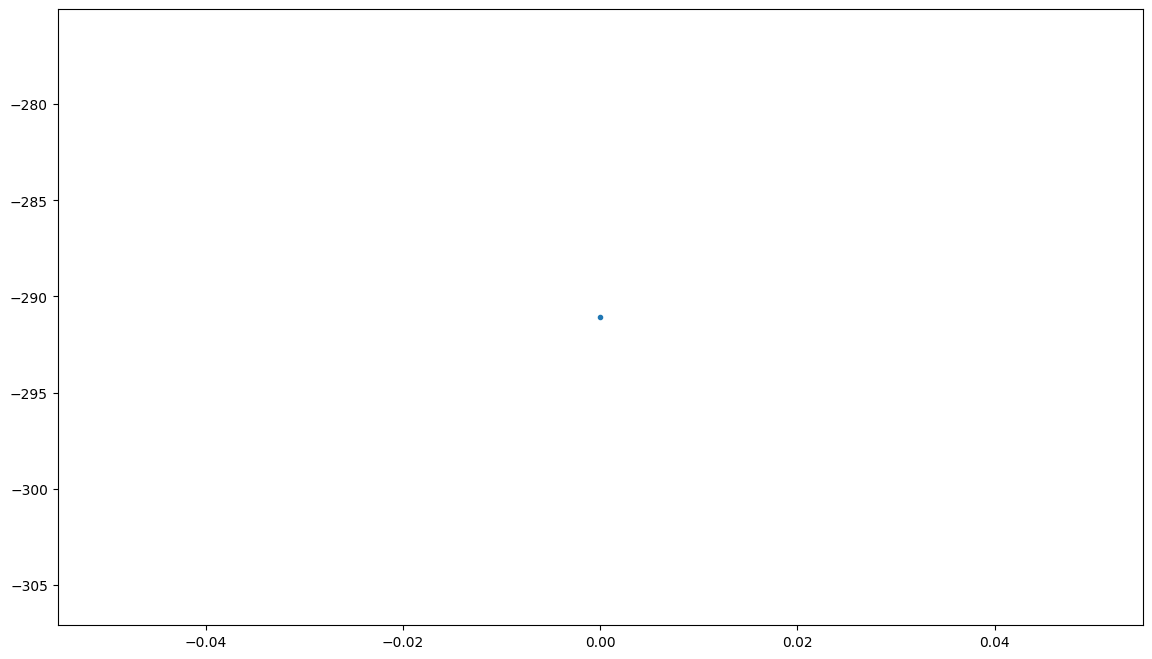

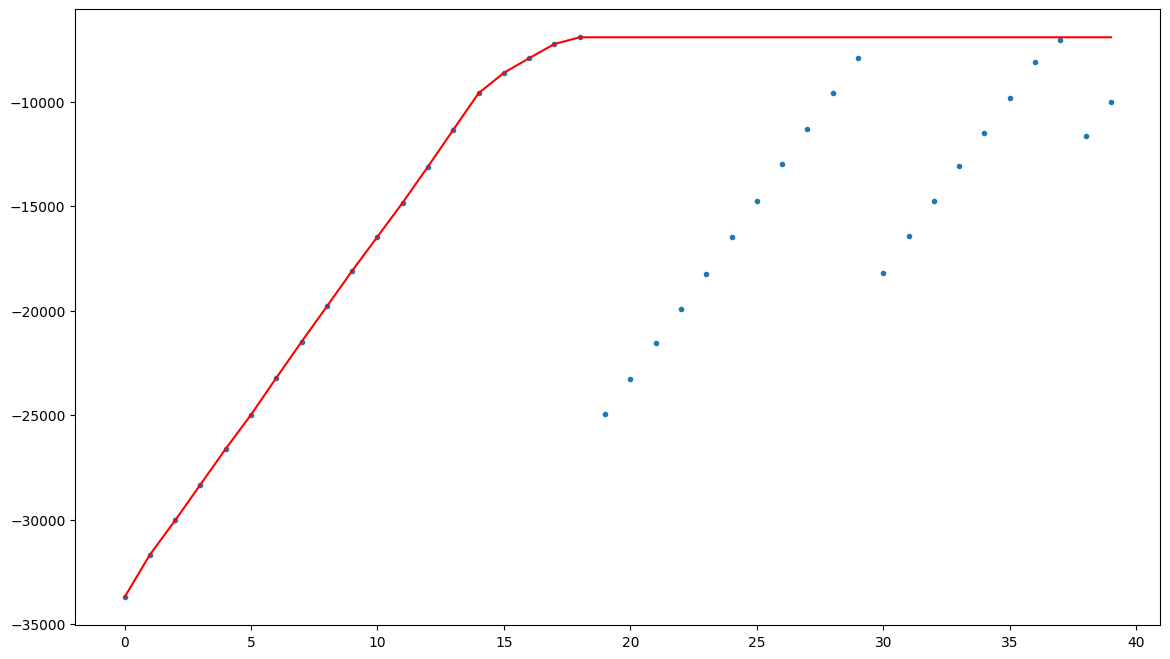

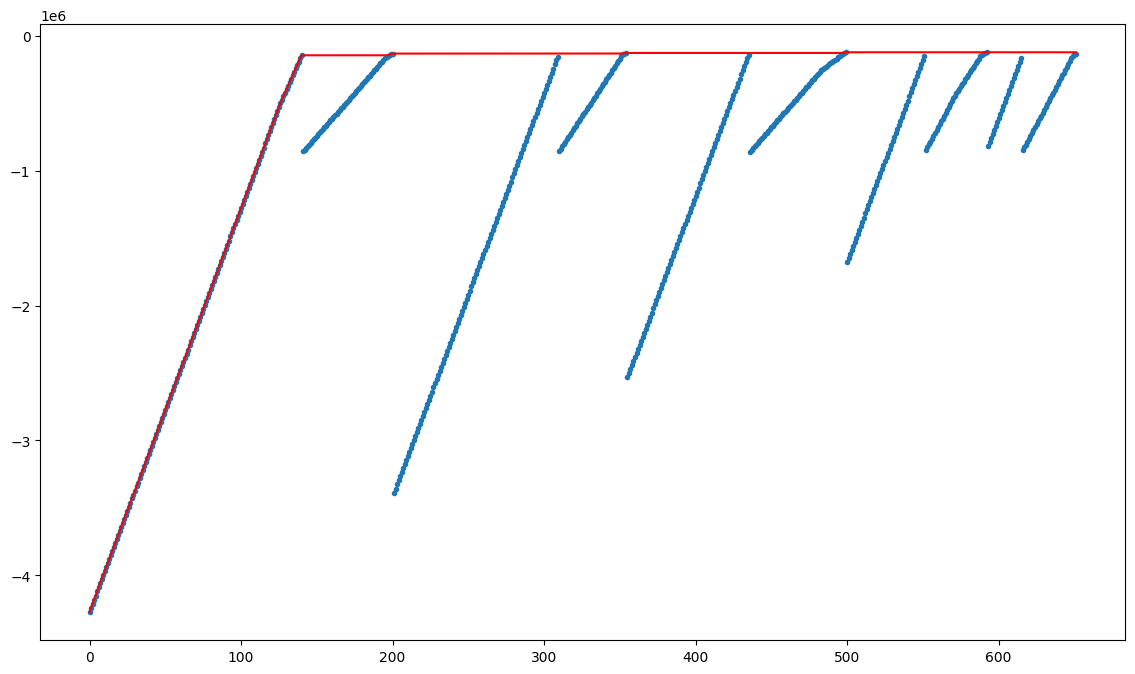

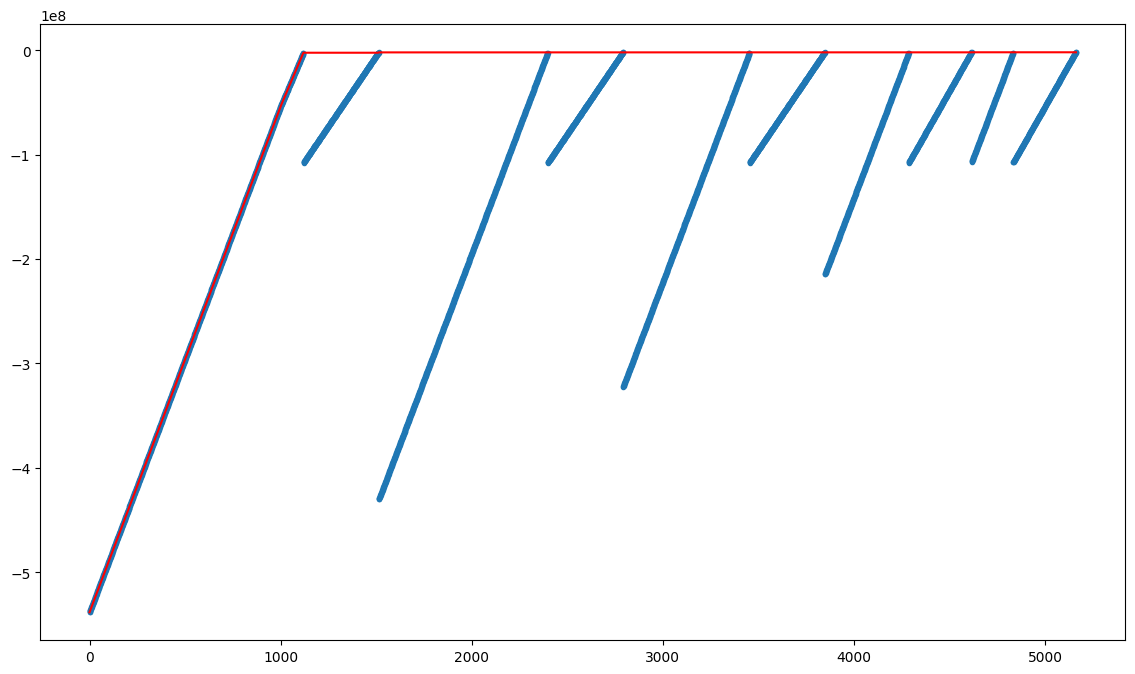

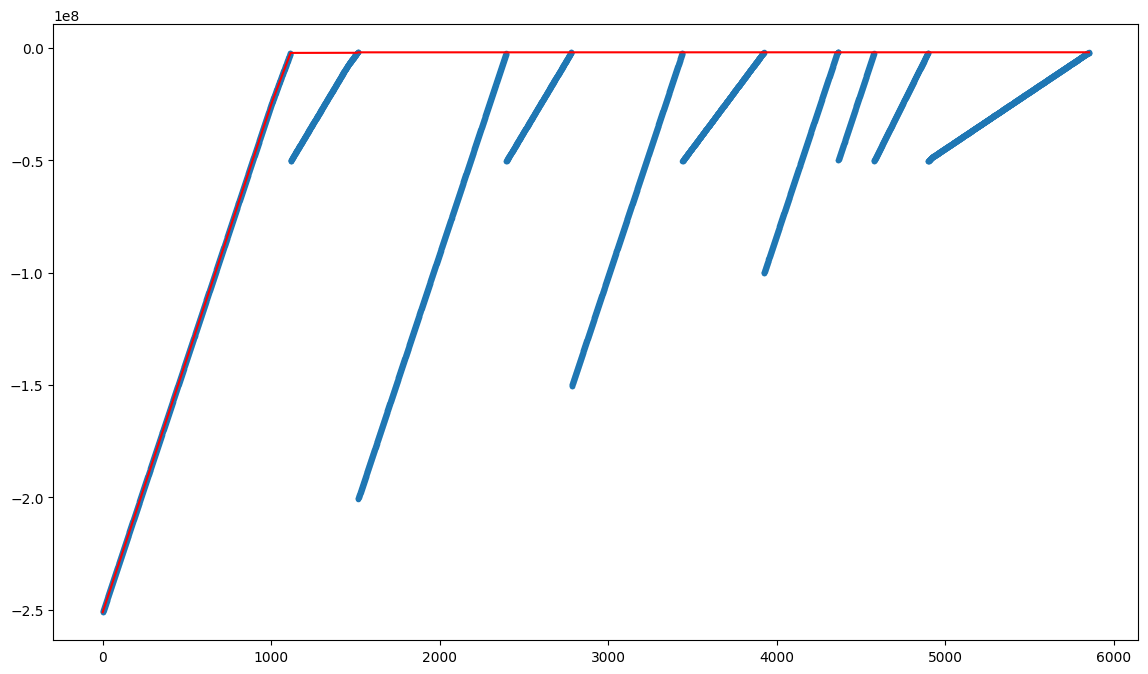

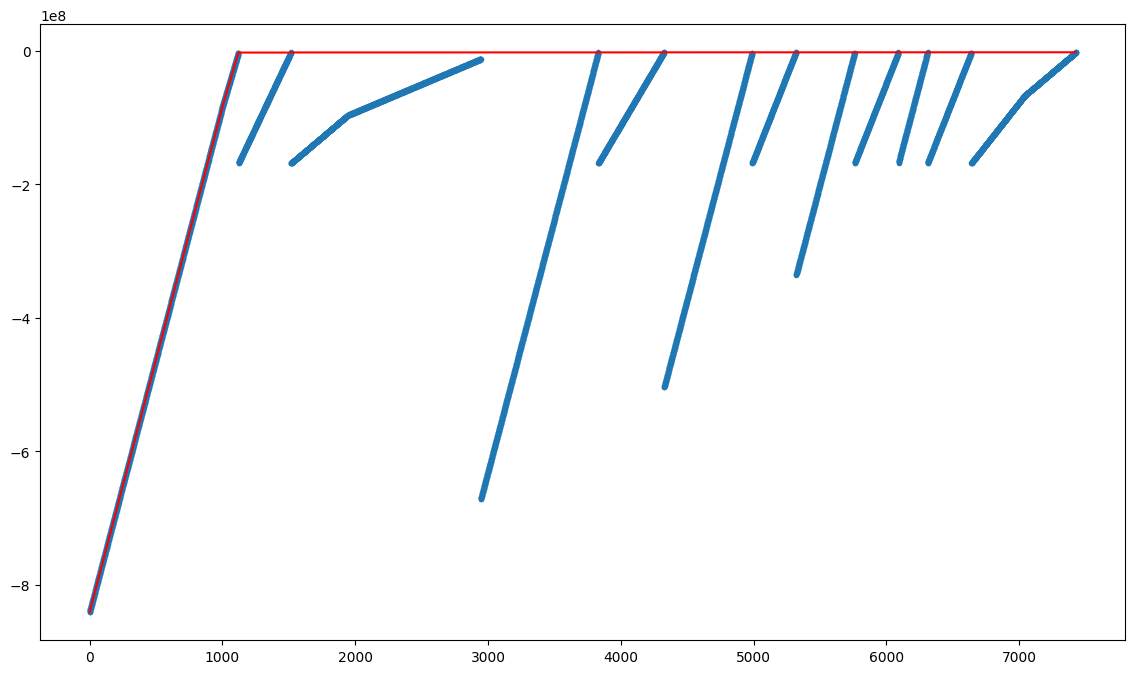

In [171]:


def resolve(uni_size,nsets,dens):

    ### generate sets and costs, this party is really slow 
    sets = np.random.random((nsets, uni_size)) < dens
    for s in range(uni_size):
        if not np.any(sets[:, s]):
            sets[np.random.randint(nsets), s] = True
    costs = np.pow(sets.sum(axis=1), 1.1)
    ### 


    current_solution =rng.random(nsets)  #inizialize current solution




    max_steps=uni_size//10  # no significant improvement in increasing 

    n_restart=5 # slightly improves results


    history = []


    for nres in tqdm(range(n_restart)):
        i=0
        num_true=int((100-(nres)*(100/n_restart))*nsets/100)
        
    
        current_solution = np.zeros(nsets, dtype=bool)  # Initialize with all False
        true_indices = rng.choice(nsets, num_true, replace=False)  # Randomly pick indices to set to True
        current_solution[true_indices] = True  # Set those indices to True

        current_fit=fitness2(current_solution,costs,sets)
        if(nres==0):  #the first solution is always right because it's all true
            defsol=current_solution[:]
            defit=fitness2(defsol,costs,sets)
            history.append(defit[1])
        for step in range(max_steps):
            i+=1  #counts steps until the last improvement
            if(i%(3*max_steps//10)==0 ):  # if it's stuck for the 30% of steps , i try to use tweak 6 
                solution = tweak6(current_solution)
                i=0
                current_solution=solution[:]
                current_fit=fitness2(solution,costs,sets)
            else:
                solution = tweak5(current_solution,step,max_steps,current_fit[0],uni_size)

            sol_fit=fitness2(solution,costs,sets)

            if sol_fit[0] and sol_fit[1]>current_fit[1] :  # if it's valid and it's better then the previus current solution , update teh current solution
                history.append(sol_fit[1])
                current_solution = solution
                current_fit=sol_fit
                i=0
                if sol_fit[1]>defit[1]:  #if it's better then the previus global solution  update global solution with the solution 
                    defsol = solution[:]
                    defit=sol_fit
        
    finalcost=cost(defsol,costs)
    ic(finalcost,valid(defsol,sets))  #show cost and if it's valid or not
    ic(history.index(defit[1])) #last improvement index



    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color="red",
    )
    _ = plt.scatter(range(len(history)), history, marker=".")
    #plt.ylim(-100167,-170167)


    with open('log.txt', 'a') as file:   # log to track how well the algorithm performs
        
        file.write(f"{uni_size} , {nsets} , {dens} , {max_steps} , {n_restart} , {finalcost} \n")
    return finalcost
    






for test in listTest:
    NCALLS=0
    resolve(test[0],test[1],test[2])
    print(NCALLS)
#pythonoptimize=1     and then start program

| Universe Size | Number of Sets | Density | Cost | Number of Times I Call Fitness Function |
|---------------|----------------|---------|------|----------------------------------------|
| 100           | 10             | 0.2     | 277.6620635309684 | 71 |
| 1000          | 100            | 0.2     | 7510.8060872504675 | 518 |
| 10000         | 1000           | 0.2     | 123795.99497518649 |  5010 |
| 100000        | 10000          | 0.1     | 2102128.359116447 |50012 |
| 100000        | 10000          | 0.2     | 1910697.4551600877 | 50011 |
| 100000        | 10000          | 0.3     | 2183831.17137303 |50014 |

